## Per-Patch Classification: Basic Convolutional Neural Network

This notebook considers training and visualization of the per-patch classifier based on a simple Convolutional Neural Network.

In [1]:
try: # Google Colab integration
  from google.colab import drive

  print('Colab environment detected. Mounting drive...')
  drive.mount('/content/drive')

  print('Mounted. Switching to directory... ', end = '')
  %cd /content/drive/'My Drive'/CILroadseg
  print('done.')
except:
  print('Colab environment not found. Working on ordinary directory.')

Colab environment detected. Mounting drive...
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Mounted. Switching to directory... /content/drive/.shortcut-targets-by-id/1hJjRuooL8LlIzLxTPjNs2UvyQkSkdMa8/CILroadseg
done.


In [2]:
import numpy as np
np.random.seed(18)

import tensorflow as tf
tf.random.set_seed(33)

import sys
import os
import matplotlib.image as mpimg

from util.submit import *      # util/submit.py contains the functions used to generate the CSV file for Kaggle Competition
from util.visualize import *   # util/visualize.py provides functions for image visualization
from util.notebooks import *   # util/notebooks.py contains various util functions used in notebooks

## Loading Training Data

`nb_load_data` is an helper function provided in `util/notebooks.py`

In [3]:
train_dir = "training/images/"
gt_dir = "training/groundtruth/"
test_dir = "test/images/"

X, Y, X_test = nb_load_data(train_dir, gt_dir, test_dir)

Y = (Y >= 0.25) * 1

Loading training input...
Progress: done (100 images).
Loading training groundtruth...
Progress: done (100 images).
Loading test input...
Progress: done (94 images).

       Training data shape: (100, 400, 400, 3)
Training groundtruth shape: (100, 400, 400)
           Test data shape: (94, 608, 608, 3)


## Working with the Model

The `ConvNetModel` and `Decomposer` classes are subclasses of `ModelBase`.
This base class can be found in `util/model_base.py` and provides a common interface to all the models we created.

In particular:
- `initialize()` resets the state of the object and should be called before the training starts
- `train(Y, X)` takes the training data `X` and its groundtruth `Y` to train the model
- `classify(X)` returns the predictions for `X`
- `load(filename)` and `save(filename)` load and save weights of the Neural Network from file.

---

The `Decomposer` class is a decorator which performs bootstrapping and data augmentation for all the per-patch classifiers (in this case `ConvNetModel`).

The `Discretizer` decorator transforms the output of the inner model from [0, 1] to {0, 1} rounding to either 0 or 1 based on the given threshold.

One can allocate a model like below.

In [4]:
from tensorflow import keras

from decomposer import *
from discretize import *
from cnn import *

Using TensorFlow backend.


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 196, 196, 32)      2432      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 196, 196, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 196, 196, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 98, 98, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 64)        18496     
_________________________________________________________________
re_lu_2 (ReLU)               (None, 96, 96, 64)        0   

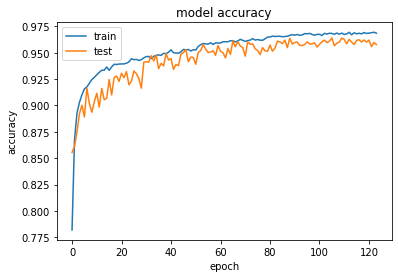

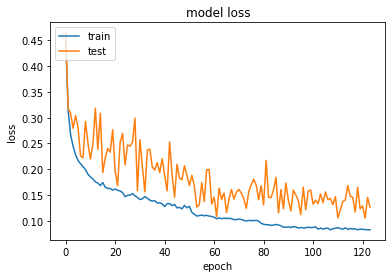

In [5]:
core_model = ConvNetModel()
# Definition of this class can be found in cnn.py

model = Decomposer(core_model, window_size=200)
# This model looks at a window of size 200

model = Discretizer(model, threshold=0.5)


DO_TRAINING = True
if DO_TRAINING:
  model.initialize()
  model.train(Y, X)

  model.save("saves/final/cnn.h5")
else:
  model.initialize()
  model.load("saves/final/cnn.h5")

## Making Predictions with the Model

`Decomposer.classify(X)` decomposes the images of `X` into windows and then calls `ConvNetModel.classify(X)` to do the patchwise classification, but it **does not** recompose the images. This is true for all the patchwise classifiers we created, because having patchwise predictions can be useful in certain cases.

If you want the model to return full masks, you need to wrap it into a `Recomposer` decorator, as below. The implementation of this decorator class can be found in `recomposer.py`.

In [6]:
from recomposer import *
model = Recomposer(model)

The function `nb_predict_masks` is an helper function provided in `util/notebooks.py`, while `masks_to_submission` is a function based on the implementation provided in the Kaggle competition.

The following two cells can be skipped if you do not want to generate the `.csv` file.

In [7]:
test_masks_dir = "test/pred/cnn/"
test_dir = "test/images/"
 
nb_predict_masks(model, test_dir, test_masks_dir)

Predicting test cases... 
Progress: done.


In [8]:
image_paths = [test_masks_dir + file for file in os.listdir(test_masks_dir)]
masks_to_submission("test/cnn.csv", image_paths)

This prediction achieved an F1 score of XXX in Kaggle's public test set.

# Visualizing predictions

The function `view_image_array` is provided in `util/visualize.py`. It uses `matplotlib` to visualize the images and the corresponding predictions.

In [9]:
Y_pred = model.classify(X_test[0:10])

view_image_array(X_test[0:10], Y_pred)

Output hidden; open in https://colab.research.google.com to view.